# Cardinal Alignment

Rotation procedure from ordered linearly independent vectors to cardinal directions. This procedure is based on the work ["Rethinking the Benefits of Steerable Features in 3D Equivariant Graph Neural Networks"](https://iclr.cc/virtual/2024/poster/17900)


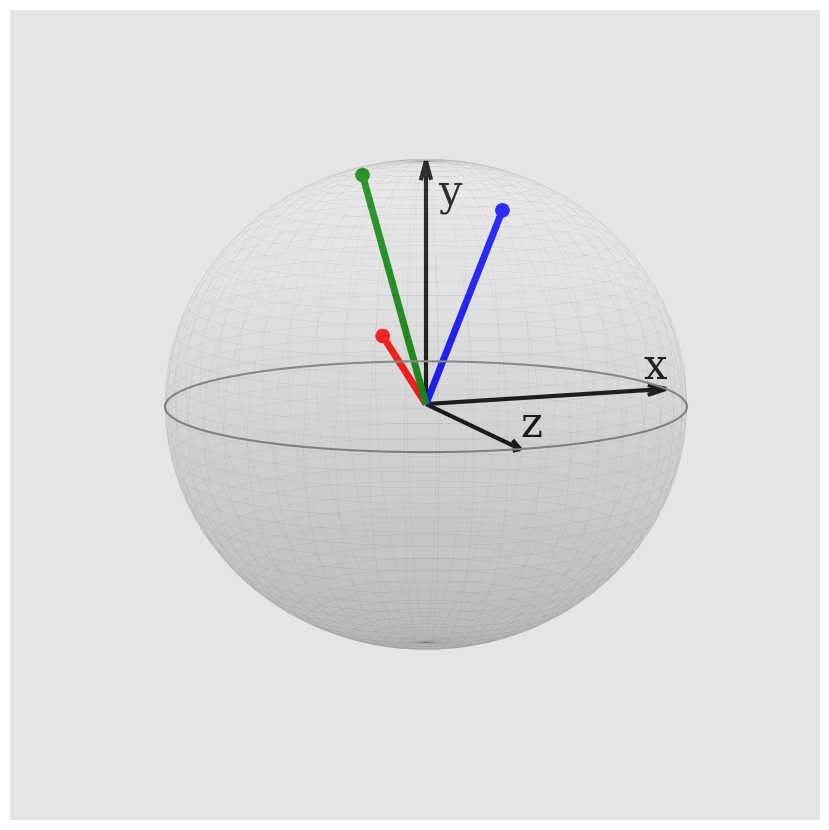

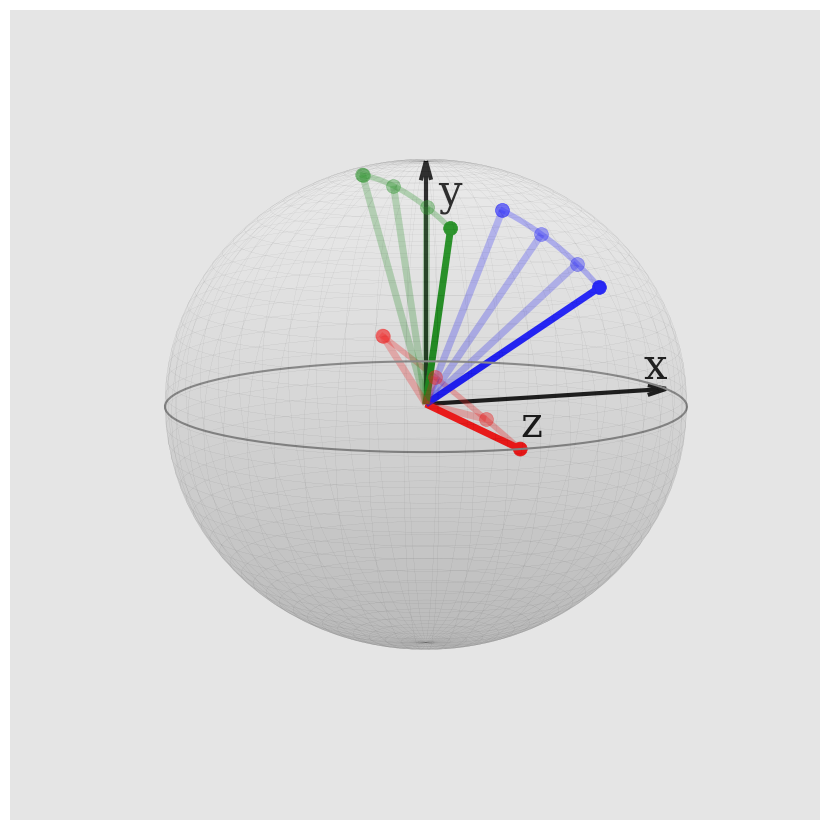

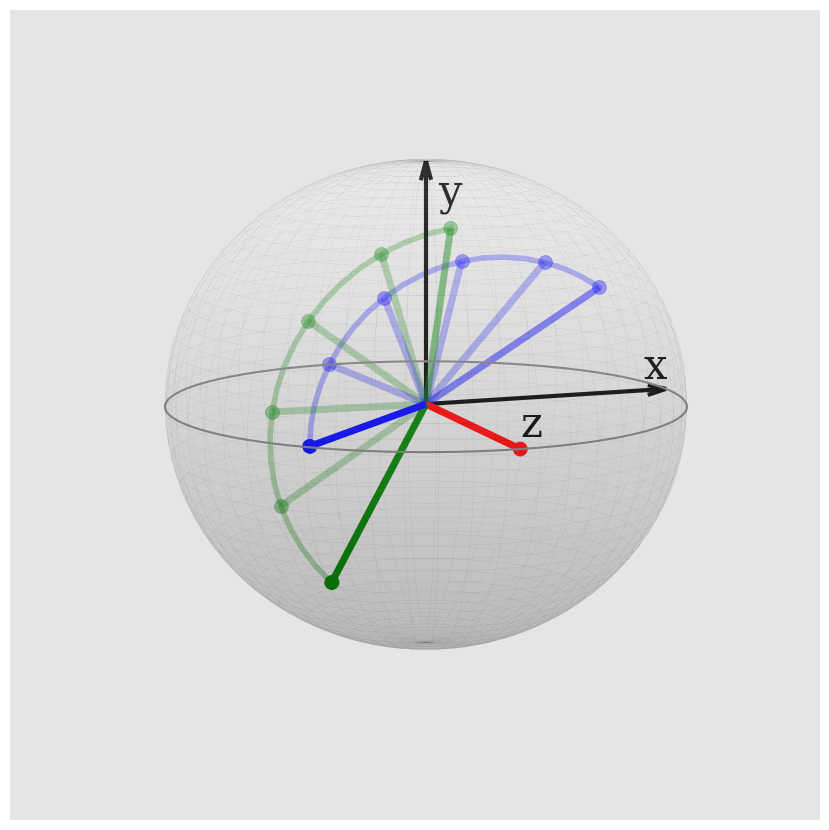

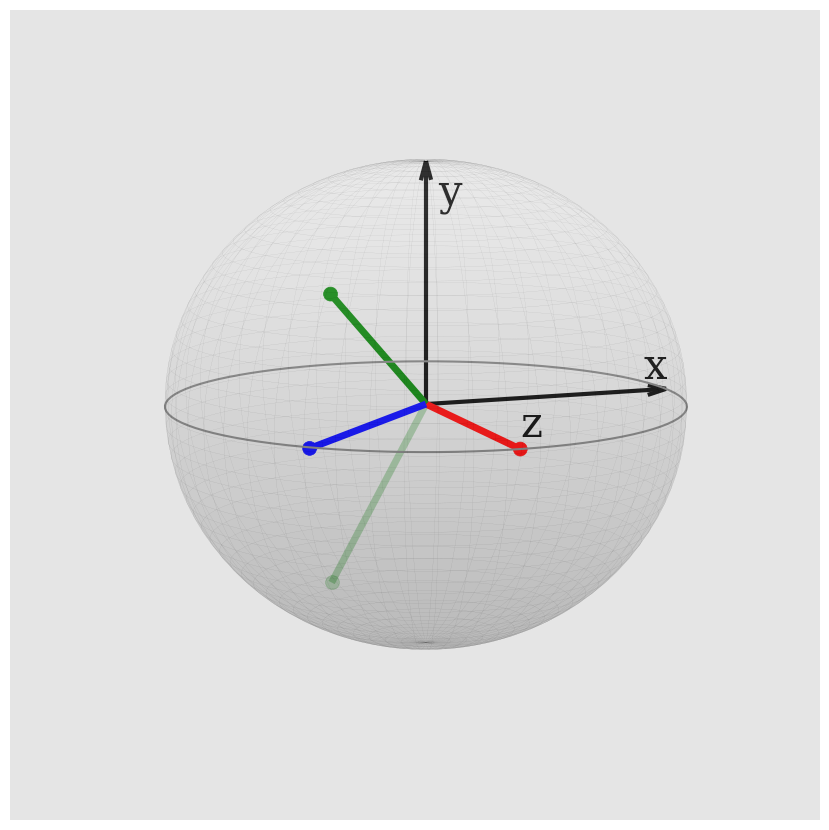

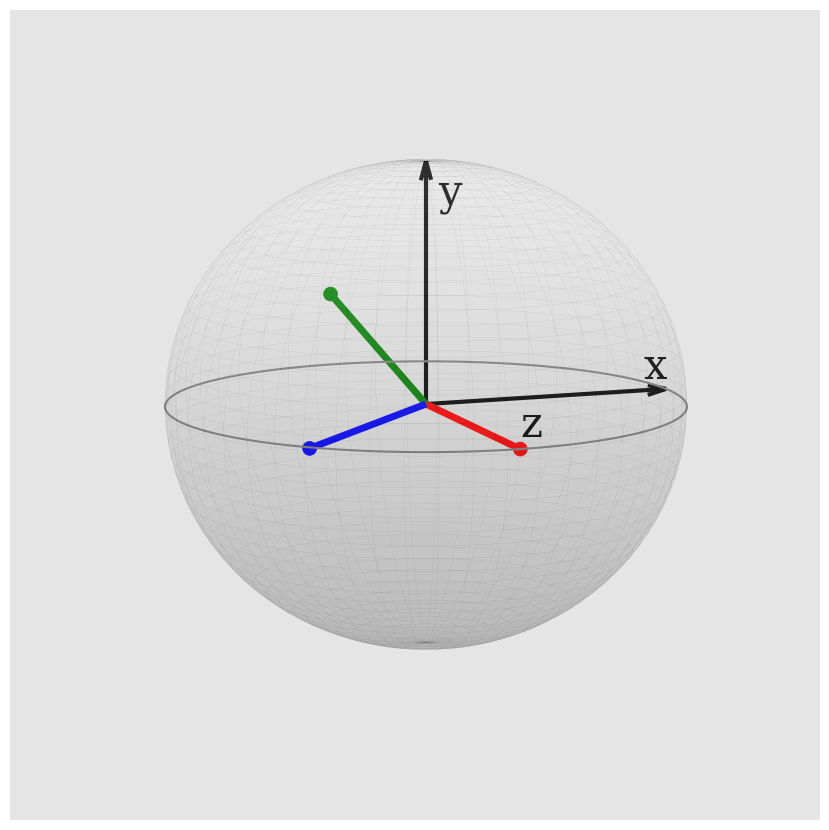

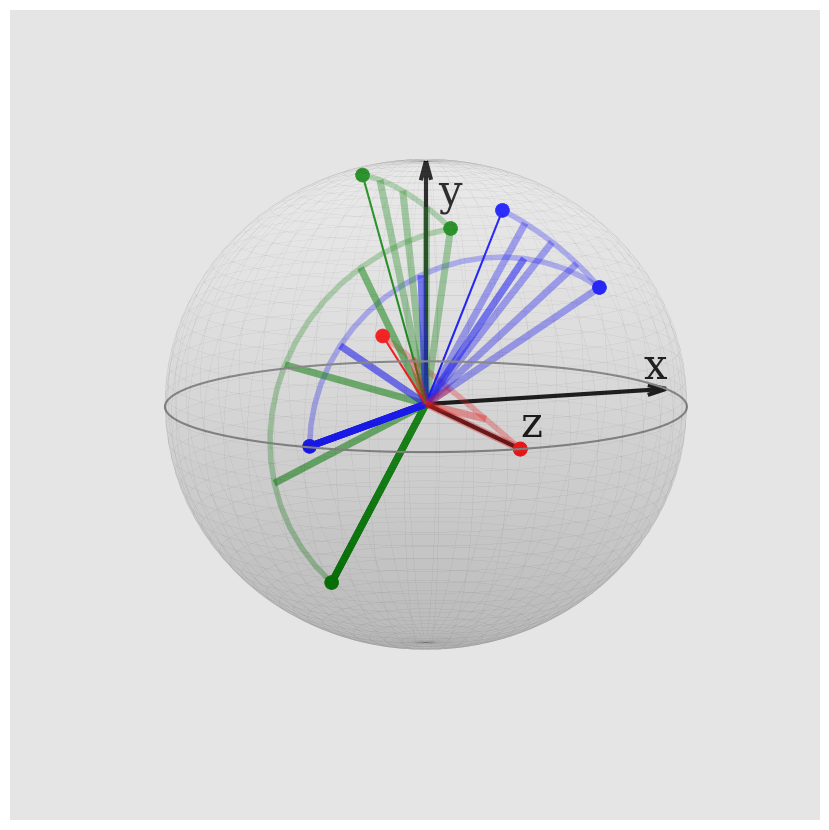

In [1]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import matplotlib.pyplot as plt
import numpy as np

#-----------------------------------------------------------------------------------------------------------------------------------------------------
# Settings
#-----------------------------------------------------------------------------------------------------------------------------------------------------

np.random.seed(1)

plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (16,9)
plt.rcParams["font.size"] = 30
plt.rcParams["font.family"] = 'serif'
plt.rcParams['mathtext.default'] = 'default'
# plt.rcParams["font.weight"] = 'bold'
plt.rcParams["xtick.color"] = 'black'
plt.rcParams["ytick.color"] = 'black'
plt.rcParams["axes.edgecolor"] = 'black'
plt.rcParams["axes.linewidth"] = 1

from scipy.spatial.transform import Rotation as R

AZIM=70
L_THC = 4
L_OP = .3
P_THC = 100
P_OP = .4
V_THC = 5
V_OP = .1
A_LEN=0.
AX_LEN=0.08
AX_STY='_x'


def rotation_matrix_from_A_to_B(A, B, t):
    A = A / np.linalg.norm(A)
    B = B / np.linalg.norm(B)
    axis = np.cross(A, B)
    if np.allclose(axis, np.zeros_like(axis)):
        return np.identity(3)
    axis = axis / np.linalg.norm(axis)
    angle = np.arccos(np.dot(A, B)) * t
    return np.array([[np.cos(angle) + axis[0]**2 * (1 - np.cos(angle)),
                      axis[0] * axis[1] * (1 - np.cos(angle)) - axis[2] * np.sin(angle),
                      axis[0] * axis[2] * (1 - np.cos(angle)) + axis[1] * np.sin(angle)],
                     [axis[1] * axis[0] * (1 - np.cos(angle)) + axis[2] * np.sin(angle),
                      np.cos(angle) + axis[1]**2 * (1 - np.cos(angle)),
                      axis[1] * axis[2] * (1 - np.cos(angle)) - axis[0] * np.sin(angle)],
                     [axis[2] * axis[0] * (1 - np.cos(angle)) - axis[1] * np.sin(angle),
                      axis[2] * axis[1] * (1 - np.cos(angle)) + axis[0] * np.sin(angle),
                      np.cos(angle) + axis[2]**2 * (1 - np.cos(angle))]])

#-----------------------------------------------------------------------------------------------------------------------------------------------------
# Init
#-----------------------------------------------------------------------------------------------------------------------------------------------------

fig = plt.figure(tight_layout=True)
ax = fig.add_subplot(111, projection='3d')

ax.set_axis_off()
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
ax.set_xlim([-1,1])
ax.set_ylim([-1,1])
ax.set_zlim([-.8,.8])

origin = [0,0,0]
x = [-1,0,0]
y = [0,1,0]
z = [0,0,1]
ax.quiver(origin[0], origin[1], origin[2], x[0], x[1], x[2], color='k', linewidth=3, arrow_length_ratio=AX_LEN)
ax.quiver(origin[0], origin[1], origin[2], y[0], y[1], y[2], color='k', linewidth=3, arrow_length_ratio=AX_LEN)
ax.quiver(origin[0], origin[1], origin[2], z[0], z[1], z[2], color='k', linewidth=3, arrow_length_ratio=AX_LEN)

ax.view_init(elev=10, azim=AZIM)
ax.shade = True

# Surface

u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)
x = np.outer(np.cos(u), np.sin(v))
y = np.outer(np.sin(u), np.sin(v))
z = np.outer(np.ones(np.size(u)), np.cos(v))
surf = ax.plot_surface(x, y, z, cmap=cm.Greys_r, alpha=.1, linewidth=.1, edgecolor='k')

# Plane
r = 1
center = (0, 0, 0)
phi = np.linspace(0, np.pi, 100)
theta = np.linspace(0, 2 * np.pi, 100)
x = r * np.outer(np.cos(theta), np.sin(phi)) + center[0]
y = r * np.outer(np.sin(theta), np.sin(phi)) + center[1]
z = r * np.outer(np.ones(np.size(theta)), np.cos(phi)) + center[2]
plt.contour(x, y, z, [0], colors='grey')

# Data
data = np.array([[1,0,0],[1,1,0],[1,1,1]])
data = np.array([dat / np.linalg.norm(dat) for dat in data])
angle1 = np.pi/3  # rotation angle
axis1 = [0, 0, 1]  # rotation axis
angle2 = -np.pi/7  # rotation angle
axis2 = [0, 1, 0]  # rotation axis
angle3 = np.pi/3  # rotation angle
axis3 = [1, 0, 0]  # rotation axis
rot1 = R.from_rotvec(angle1 * np.array(axis1)).as_matrix()
rot2 = R.from_rotvec(angle2 * np.array(axis2)).as_matrix()
rot3 = R.from_rotvec(angle3 * np.array(axis3)).as_matrix()

ndata =  rot1 @ rot2 @ rot3 @ data.T
_, S, _ = np.linalg.svd(ndata)
assert np.all(S > 1e-14)

ax.scatter(ndata[0], ndata[1], ndata[2], color=['r','b','g'], alpha=1.0, s=P_THC)
x0,y0,z0=center, center, center
x1,y1,z1=ndata[0],ndata[1],ndata[2]
ax.quiver(x0, y0, z0, x1, y1, z1, color=['r','b','g'], arrow_length_ratio=0, linewidth=V_THC)


if AX_STY=='_x':
    ax.text(-.9, 0, .05, "$x$", color='k')
    ax.text(-.02, .95, .035, "$z$", color='k')
    ax.text(-.05, 0, .82, "$y$", color='k')

plt.savefig(f'../out/init{AX_STY}.pdf',bbox_inches='tight')

#-----------------------------------------------------------------------------------------------------------------------------------------------------
# Align
#-----------------------------------------------------------------------------------------------------------------------------------------------------

fig = plt.figure(tight_layout=True)
ax = fig.add_subplot(111, projection='3d')

# Axis

ax.set_axis_off()
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
ax.set_xlim([-1,1])
ax.set_ylim([-1,1])
ax.set_zlim([-.8,.8])
# create the standard basis vectors
origin = [0,0,0]
x = [-1,0,0]
y = [0,1,0]
z = [0,0,1]
ax.quiver(origin[0], origin[1], origin[2], x[0], x[1], x[2], color='k', linewidth=3, arrow_length_ratio=AX_LEN)
ax.quiver(origin[0], origin[1], origin[2], y[0], y[1], y[2], color='k', linewidth=3, arrow_length_ratio=0)
ax.quiver(origin[0], origin[1], origin[2], z[0], z[1], z[2], color='k', linewidth=3, arrow_length_ratio=AX_LEN)

# orient
ax.view_init(elev=10, azim=AZIM)
ax.shade = True


# Surface
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)
x = np.outer(np.cos(u), np.sin(v))
y = np.outer(np.sin(u), np.sin(v))
z = np.outer(np.ones(np.size(u)), np.cos(v))
surf = ax.plot_surface(x, y, z, cmap=cm.Greys_r, alpha=.1, linewidth=.1, edgecolor='k')

# Plane
r = 1
center = (0, 0, 0)
phi = np.linspace(0, np.pi, 100)
theta = np.linspace(0, 2 * np.pi, 100)
x = r * np.outer(np.cos(theta), np.sin(phi)) + center[0]
y = r * np.outer(np.sin(theta), np.sin(phi)) + center[1]
z = r * np.outer(np.ones(np.size(theta)), np.cos(phi)) + center[2]
plt.contour(x, y, z, [0], colors='grey')

# Data
data = np.array([[1,0,0],[1,1,0],[1,1,1]])
data = np.array([dat / np.linalg.norm(dat) for dat in data])
angle1 = np.pi/3  # rotation angle
axis1 = [0, 0, 1]  # rotation axis
angle2 = -np.pi/7  # rotation angle
axis2 = [0, 1, 0]  # rotation axis
angle3 = np.pi/3  # rotation angle
axis3 = [1, 0, 0]  # rotation axis
rot1 = R.from_rotvec(angle1 * np.array(axis1)).as_matrix()
rot2 = R.from_rotvec(angle2 * np.array(axis2)).as_matrix()
rot3 = R.from_rotvec(angle3 * np.array(axis3)).as_matrix()

ndata =  rot1 @ rot2 @ rot3 @ data.T
_, S, _ = np.linalg.svd(ndata)
assert np.all(S > 1e-14)


# First Rotation

num_points = 20
freq = 7

ax.scatter(ndata[0], ndata[1], ndata[2], color=['r','b','g'], alpha=P_OP, s=P_THC)
x0,y0,z0=center, center, center
x1,y1,z1=ndata[0],ndata[1],ndata[2]
# ax.quiver(x0, y0, z0, x1, y1, z1, color=['r','b','g'], linewidth=3, alpha=.5, arrow_length_ratio=.08)

start = ndata[:,0]
end = np.array([0, 1, 0])
rot = lambda t : rotation_matrix_from_A_to_B(start, end, t)
rot_fixed = rotation_matrix_from_A_to_B(start, end, 1)
diff = end-start
points = np.zeros((num_points, 3))
for i in range(num_points):
    t = i / (num_points - 1)
    points[i] = rot(t) @ start
    points[i] = points[i]/np.linalg.norm(points[i])
    if (i)%freq==0:
        ax.quiver(x0, y0, z0, points[i,0], points[i,1], points[i,2], color='r', alpha=V_OP, linewidth=V_THC, arrow_length_ratio=A_LEN)
        ax.scatter(*points[i], color='r',alpha=P_OP, s=P_THC)
ax.plot(*points.T, color='red',alpha=L_OP, linewidth=L_THC)

data2 = end

start = ndata[:,1]
end = rot_fixed @ start 
rot = lambda t : rotation_matrix_from_A_to_B(start, end, t)
points = np.zeros((num_points, 3))
for i in range(num_points):
    t = i / (num_points - 1)
    points[i] = rot(t) @ start
    points[i] = points[i]/np.linalg.norm(points[i])
    if (i)%freq==0:
        ax.quiver(x0, y0, z0, points[i,0], points[i,1], points[i,2], color='b', alpha=V_OP, linewidth=V_THC, arrow_length_ratio=A_LEN)
        ax.scatter(*points[i], color='b',alpha=P_OP, s=P_THC)
ax.plot(*points.T, color='b',alpha=L_OP, linewidth=L_THC)


data2 = np.vstack([data2,end])

start = ndata[:,2]
end = rot_fixed @ start 
rot = lambda t : rotation_matrix_from_A_to_B(start, end, t)
points = np.zeros((num_points, 3))
for i in range(num_points):
    t = i / (num_points - 1)
    points[i] = rot(t) @ start
    points[i] = points[i]/np.linalg.norm(points[i])
    if (i)%freq==0:
        ax.quiver(x0, y0, z0, points[i,0], points[i,1], points[i,2], color='g', alpha=V_OP, linewidth=V_THC, arrow_length_ratio=A_LEN)
        ax.scatter(*points[i], color='g',alpha=P_OP, s=P_THC)
ax.plot(*points.T, color='g',alpha=L_OP, linewidth=L_THC)

data2 = np.vstack([data2,end]).T

x0,y0,z0=center, center, center
x1,y1,z1=data2[0],data2[1],data2[2]
# ax.quiver(x0, y0, z0, x1, y1, z1, color=['k','b','g'], linewidth=V_THC, arrow_length_ratio=0)
ax.quiver(x0, y0, z0, x1, y1, z1, color=['r','b','g'], linewidth=V_THC, arrow_length_ratio=0)
ax.scatter(data2[0], data2[1], data2[2], color=['r','b','g'], alpha=1.0, s=P_THC)


if AX_STY=='_x':
    ax.text(-.9, 0, .05, "$x$", color='k')
    ax.text(-.02, .95, .035, "$z$", color='k')
    ax.text(-.05, 0, .82, "$y$", color='k')
plt.savefig(f'../out/align{AX_STY}.pdf',bbox_inches='tight')


#-----------------------------------------------------------------------------------------------------------------------------------------------------
# Rotate
#-----------------------------------------------------------------------------------------------------------------------------------------------------

fig = plt.figure(tight_layout=True)
ax = fig.add_subplot(111, projection='3d')

# Surface
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)
x = np.outer(np.cos(u), np.sin(v))
y = np.outer(np.sin(u), np.sin(v))
z = np.outer(np.ones(np.size(u)), np.cos(v))
surf = ax.plot_surface(x, y, z, cmap=cm.Greys_r, alpha=.1, linewidth=.1, edgecolor='k')

# Plane
r = 1
center = (0, 0, 0)
phi = np.linspace(0, np.pi, 100)
theta = np.linspace(0, 2 * np.pi, 100)
x = r * np.outer(np.cos(theta), np.sin(phi)) + center[0]
y = r * np.outer(np.sin(theta), np.sin(phi)) + center[1]
z = r * np.outer(np.ones(np.size(theta)), np.cos(phi)) + center[2]
plt.contour(x, y, z, [0], colors='grey')

# Data
data = np.array([[1,0,0],[1,1,0],[1,1,1]])
data = np.array([dat / np.linalg.norm(dat) for dat in data])
angle1 = np.pi/3  # rotation angle
axis1 = [0, 0, 1]  # rotation axis
angle2 = -np.pi/7  # rotation angle
axis2 = [0, 1, 0]  # rotation axis
angle3 = np.pi/3  # rotation angle
axis3 = [1, 0, 0]  # rotation axis
rot1 = R.from_rotvec(angle1 * np.array(axis1)).as_matrix()
rot2 = R.from_rotvec(angle2 * np.array(axis2)).as_matrix()
rot3 = R.from_rotvec(angle3 * np.array(axis3)).as_matrix()

ndata =  rot1 @ rot2 @ rot3 @ data.T
_, S, _ = np.linalg.svd(ndata)
assert np.all(S > 1e-14)

# Axis

ax.set_axis_off()
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
ax.set_xlim([-1,1])
ax.set_ylim([-1,1])
ax.set_zlim([-.8,.8])
# create the standard basis vectors
origin = [0,0,0]
x = [-1,0,0]
y = [0,1,0]
z = [0,0,1]
ax.quiver(origin[0], origin[1], origin[2], x[0], x[1], x[2], color='k', linewidth=3, arrow_length_ratio=AX_LEN)
ax.quiver(origin[0], origin[1], origin[2], y[0], y[1], y[2], color='k', linewidth=3, arrow_length_ratio=0)
ax.quiver(origin[0], origin[1], origin[2], z[0], z[1], z[2], color='k', linewidth=3, arrow_length_ratio=AX_LEN)

# orient
ax.view_init(elev=10, azim=AZIM)
ax.shade = True

# Data
data = np.array([[1,0,0],[1,1,0],[1,1,1]])
data = np.array([dat / np.linalg.norm(dat) for dat in data])
angle1 = np.pi/3  # rotation angle
axis1 = [0, 0, 1]  # rotation axis
angle2 = -np.pi/7  # rotation angle
axis2 = [0, 1, 0]  # rotation axis
angle3 = np.pi/3  # rotation angle
axis3 = [1, 0, 0]  # rotation axis
rot1 = R.from_rotvec(angle1 * np.array(axis1)).as_matrix()
rot2 = R.from_rotvec(angle2 * np.array(axis2)).as_matrix()
rot3 = R.from_rotvec(angle3 * np.array(axis3)).as_matrix()

ndata =  rot1 @ rot2 @ rot3 @ data.T
_, S, _ = np.linalg.svd(ndata)
assert np.all(S > 1e-14)

# First Rotation

num_points = 20
freq = 4

start = ndata[:,0]
end = np.array([0, 1, 0])
data2 = end

start = ndata[:,1]
end = rot_fixed @ start 
data2 = np.vstack([data2,end])

start = ndata[:,2]
end = rot_fixed @ start 
data2 = np.vstack([data2,end]).T

ax.scatter(data2[0], data2[1], data2[2], color=['r','b','g'], alpha=P_OP, s=P_THC)
x0,y0,z0=center, center, center
x1,y1,z1=data2[0],data2[1],data2[2]
ax.quiver(x0, y0, z0, x1, y1, z1, color=['r','b','g'], linewidth=V_THC, alpha=.5, arrow_length_ratio=0)

# Second Rotation

ztheta = np.pi - np.arccos(data2.T[1,2])+.04
yaxis = [0, 1, 0]  # rotation axis
zrot = lambda t : R.from_rotvec(t *ztheta * np.array(yaxis)).as_matrix()

start = data2[:,0]
end = zrot(1) @ start
data3 = end

start = data2[:,2]
end = zrot(1) @ start
points = np.zeros((num_points, 3))
for i in range(num_points):
    t = i / (num_points - 1)
    points[i] = zrot(t) @ start
    if (i+1)%freq==0:
        ax.quiver(x0, y0, z0, points[i,0], points[i,1], points[i,2], color='g', alpha=V_OP, linewidth=V_THC, arrow_length_ratio=A_LEN)
        ax.scatter(*points[i], color='g',alpha=P_OP, s=P_THC)
ax.plot(*points.T, color='g', alpha=L_OP, linewidth=L_THC)
data3 = np.vstack([data3,end])

start = data2[:,1]
end = zrot(1) @ start
points = np.zeros((num_points, 3))
for i in range(num_points):
    t = i / (num_points - 1)
    points[i] = zrot(t) @ start
    if (i+1)%freq==0:
        ax.quiver(x0, y0, z0, points[i,0], points[i,1], points[i,2], color='b', alpha=V_OP, linewidth=V_THC, arrow_length_ratio=A_LEN)
        ax.scatter(*points[i], color='b',alpha=P_OP, s=P_THC)
ax.plot(*points.T, color='b', alpha=L_OP, linewidth=L_THC)
data3 = np.vstack([data3,end]).T


ax.scatter(data3[0], data3[1], data3[2], color=['r','g','b'], alpha=1.0, s=P_THC)
x0,y0,z0=center, center, center
x1,y1,z1=data3[0],data3[1],data3[2]
ax.quiver(x0, y0, z0, x1, y1, z1, color=['r','g','b'], linewidth=V_THC, arrow_length_ratio=0)


# SAVE


if AX_STY=='_x':
    ax.text(-.9, 0, .05, "$x$", color='k')
    ax.text(-.02, .95, .035, "$z$", color='k')
    ax.text(-.05, 0, .82, "$y$", color='k')
plt.savefig(f'../out/rotate{AX_STY}.pdf',bbox_inches='tight')

#-----------------------------------------------------------------------------------------------------------------------------------------------------
# Reflect
#-----------------------------------------------------------------------------------------------------------------------------------------------------

fig = plt.figure(tight_layout=True)
ax = fig.add_subplot(111, projection='3d')

# Surface
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)
x = np.outer(np.cos(u), np.sin(v))
y = np.outer(np.sin(u), np.sin(v))
z = np.outer(np.ones(np.size(u)), np.cos(v))
surf = ax.plot_surface(x, y, z, cmap=cm.Greys_r, alpha=.1, linewidth=.1, edgecolor='k')

# Plane
r = 1
center = (0, 0, 0)
phi = np.linspace(0, np.pi, 100)
theta = np.linspace(0, 2 * np.pi, 100)
x = r * np.outer(np.cos(theta), np.sin(phi)) + center[0]
y = r * np.outer(np.sin(theta), np.sin(phi)) + center[1]
z = r * np.outer(np.ones(np.size(theta)), np.cos(phi)) + center[2]
plt.contour(x, y, z, [0], colors='grey')
# Axis

ax.set_axis_off()
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
ax.set_xlim([-1,1])
ax.set_ylim([-1,1])
ax.set_zlim([-.8,.8])
# create the standard basis vectors
origin = [0,0,0]
x = [-1,0,0]
y = [0,1,0]
z = [0,0,1]
ax.quiver(origin[0], origin[1], origin[2], x[0], x[1], x[2], color='k', linewidth=3, arrow_length_ratio=AX_LEN)
ax.quiver(origin[0], origin[1], origin[2], y[0], y[1], y[2], color='k', linewidth=3, arrow_length_ratio=0)
ax.quiver(origin[0], origin[1], origin[2], z[0], z[1], z[2], color='k', linewidth=3, arrow_length_ratio=AX_LEN)

# orient
ax.view_init(elev=10, azim=AZIM)
ax.shade = True

# Data

x0,y0,z0=center, center, center
x1,y1,z1=data3[0,-2],data3[1,-2],data3[2,-2]
ax.quiver(x0, y0, z0, x1, y1, z1, color=['g'], arrow_length_ratio=0, linewidth=V_THC, alpha=.1)
ax.scatter(data3[0,-2], data3[1,-2], data3[2,-2], color=['g'], alpha=0.2, s=P_THC)
x1,y1,z1=data3[0],data3[1],-data3[2]
ax.quiver(x0, y0, z0, x1, y1, z1, color=['r','g','b'], arrow_length_ratio=0, linewidth=V_THC)
ax.scatter(data3[0], data3[1], -data3[2], color=['r','g','b'], alpha=1.0, s=P_THC)


if AX_STY=='_x':
    ax.text(-.9, 0, .05, "$x$", color='k')
    ax.text(-.02, .95, .035, "$z$", color='k')
    ax.text(-.05, 0, .82, "$y$", color='k')
plt.savefig(f'../out/reflect{AX_STY}.pdf',bbox_inches='tight')


#-----------------------------------------------------------------------------------------------------------------------------------------------------
# Final
#-----------------------------------------------------------------------------------------------------------------------------------------------------

fig = plt.figure(tight_layout=True)
ax = fig.add_subplot(111, projection='3d')

# Surface
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)
x = np.outer(np.cos(u), np.sin(v))
y = np.outer(np.sin(u), np.sin(v))
z = np.outer(np.ones(np.size(u)), np.cos(v))
surf = ax.plot_surface(x, y, z, cmap=cm.Greys_r, alpha=.1, linewidth=.1, edgecolor='k')

# Plane
r = 1
center = (0, 0, 0)
phi = np.linspace(0, np.pi, 100)
theta = np.linspace(0, 2 * np.pi, 100)
x = r * np.outer(np.cos(theta), np.sin(phi)) + center[0]
y = r * np.outer(np.sin(theta), np.sin(phi)) + center[1]
z = r * np.outer(np.ones(np.size(theta)), np.cos(phi)) + center[2]
plt.contour(x, y, z, [0], colors='grey')
# Axis

ax.set_axis_off()
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
ax.set_xlim([-1,1])
ax.set_ylim([-1,1])
ax.set_zlim([-.8,.8])
# create the standard basis vectors
origin = [0,0,0]
x = [-1,0,0]
y = [0,1,0]
z = [0,0,1]
ax.quiver(origin[0], origin[1], origin[2], x[0], x[1], x[2], color='k', linewidth=3, arrow_length_ratio=AX_LEN)
ax.quiver(origin[0], origin[1], origin[2], y[0], y[1], y[2], color='k', linewidth=3, arrow_length_ratio=0)
ax.quiver(origin[0], origin[1], origin[2], z[0], z[1], z[2], color='k', linewidth=3, arrow_length_ratio=AX_LEN)

# orient
ax.view_init(elev=10, azim=AZIM)
ax.shade = True

# Data

x0,y0,z0=center, center, center
x1,y1,z1=data3[0],data3[1],-data3[2]
ax.scatter(data3[0], data3[1], -data3[2], color=['r','g','b'], alpha=1.0, s=P_THC)
ax.quiver(x0, y0, z0, x1, y1, z1, color=['r','g','b'], arrow_length_ratio=0, linewidth=V_THC)


if AX_STY=='_x':
    ax.text(-.9, 0, .05, "$x$", color='k')
    ax.text(-.02, .95, .035, "$z$", color='k')
    ax.text(-.05, 0, .82, "$y$", color='k')
plt.savefig(f'../out/final{AX_STY}.pdf',bbox_inches='tight')

#-----------------------------------------------------------------------------------------------------------------------------------------------------
# Transit
#-----------------------------------------------------------------------------------------------------------------------------------------------------

fig = plt.figure(tight_layout=True)
ax = fig.add_subplot(111, projection='3d')

# Axis

ax.set_axis_off()
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
ax.set_xlim([-1,1])
ax.set_ylim([-1,1])
ax.set_zlim([-.8,.8])
# create the standard basis vectors
origin = [0,0,0]
x = [-1,0,0]
y = [0,1,0]
z = [0,0,1]
ax.quiver(origin[0], origin[1], origin[2], x[0], x[1], x[2], color='k', linewidth=3, arrow_length_ratio=AX_LEN)
ax.quiver(origin[0], origin[1], origin[2], y[0], y[1], y[2], color='k', linewidth=3, arrow_length_ratio=0)
ax.quiver(origin[0], origin[1], origin[2], z[0], z[1], z[2], color='k', linewidth=3, arrow_length_ratio=AX_LEN)

# orient
ax.view_init(elev=10, azim=AZIM)
ax.shade = True


# Surface
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)
x = np.outer(np.cos(u), np.sin(v))
y = np.outer(np.sin(u), np.sin(v))
z = np.outer(np.ones(np.size(u)), np.cos(v))
surf = ax.plot_surface(x, y, z, cmap=cm.Greys_r, alpha=.1, linewidth=.1, edgecolor='k')

# Plane
r = 1
center = (0, 0, 0)
phi = np.linspace(0, np.pi, 100)
theta = np.linspace(0, 2 * np.pi, 100)
x = r * np.outer(np.cos(theta), np.sin(phi)) + center[0]
y = r * np.outer(np.sin(theta), np.sin(phi)) + center[1]
z = r * np.outer(np.ones(np.size(theta)), np.cos(phi)) + center[2]
plt.contour(x, y, z, [0], colors='grey')

# Data
data = np.array([[1,0,0],[1,1,0],[1,1,1]])
data = np.array([dat / np.linalg.norm(dat) for dat in data])
angle1 = np.pi/3  # rotation angle
axis1 = [0, 0, 1]  # rotation axis
angle2 = -np.pi/7  # rotation angle
axis2 = [0, 1, 0]  # rotation axis
angle3 = np.pi/3  # rotation angle
axis3 = [1, 0, 0]  # rotation axis
rot1 = R.from_rotvec(angle1 * np.array(axis1)).as_matrix()
rot2 = R.from_rotvec(angle2 * np.array(axis2)).as_matrix()
rot3 = R.from_rotvec(angle3 * np.array(axis3)).as_matrix()

ndata =  rot1 @ rot2 @ rot3 @ data.T
_, S, _ = np.linalg.svd(ndata)
assert np.all(S > 1e-14)

ax.scatter(ndata[0], ndata[1], ndata[2], color=['r','b','g'], alpha=1.0, s=P_THC)
x0,y0,z0=center, center, center
x1,y1,z1=ndata[0],ndata[1],ndata[2]
ax.quiver(x0, y0, z0, x1, y1, z1, color=['r','b','g'], arrow_length_ratio=0)


# First Rotation

num_points = 20
freq = 5

start = ndata[:,0]
end = np.array([0, 1, 0])
rot = lambda t : rotation_matrix_from_A_to_B(start, end, t)
rot_fixed = rotation_matrix_from_A_to_B(start, end, 1)
diff = end-start
points = np.zeros((num_points, 3))
for i in range(num_points):
    t = i / (num_points - 1)
    alpha = 0.15# if i<num_points-1 else 1
    points[i] = rot(t) @ start
    points[i] = points[i]/np.linalg.norm(points[i])
    if (i+1)%freq==0:
        ax.quiver(x0, y0, z0, points[i,0], points[i,1], points[i,2], color='r', alpha=alpha, linewidth=V_THC, arrow_length_ratio=A_LEN)
ax.plot(*points.T, color='red',alpha=L_OP,linewidth=L_THC)

data2 = end

start = ndata[:,1]
end = rot_fixed @ start 
rot = lambda t : rotation_matrix_from_A_to_B(start, end, t)
points = np.zeros((num_points, 3))
for i in range(num_points):
    alpha = 0.15# if i<num_points-1 else 1
    t = i / (num_points - 1)
    points[i] = rot(t) @ start
    points[i] = points[i]/np.linalg.norm(points[i])
    if (i+1)%freq==0:
        ax.quiver(x0, y0, z0, points[i,0], points[i,1], points[i,2], color='b', alpha=alpha, linewidth=V_THC, arrow_length_ratio=A_LEN)
ax.plot(*points.T, color='b',alpha=L_OP,linewidth=L_THC)


data2 = np.vstack([data2,end])

start = ndata[:,2]
end = rot_fixed @ start 
rot = lambda t : rotation_matrix_from_A_to_B(start, end, t)
points = np.zeros((num_points, 3))
for i in range(num_points):
    alpha = 0.15# if i<num_points-1 else 1
    t = i / (num_points - 1)
    points[i] = rot(t) @ start
    points[i] = points[i]/np.linalg.norm(points[i])
    if (i+1)%freq==0:
        ax.quiver(x0, y0, z0, points[i,0], points[i,1], points[i,2], color='g', alpha=alpha, linewidth=V_THC, arrow_length_ratio=A_LEN)
ax.plot(*points.T, color='g',alpha=L_OP,linewidth=L_THC)

data2 = np.vstack([data2,end]).T
ax.scatter(data2[0], data2[1], data2[2], color=['r','b','g'], alpha=1.0, s=P_THC)

# Second Rotation
ztheta = np.pi - np.arccos(data2.T[1,2])+.04
yaxis = [0, 1, 0]  # rotation axis
zrot = lambda t : R.from_rotvec(t *ztheta * np.array(yaxis)).as_matrix()

start = data2[:,0]
end = zrot(1) @ start
data3 = end

start = data2[:,2]
end = zrot(1) @ start
points = np.zeros((num_points, 3))
for i in range(num_points):
    alpha = 0.25 if i<num_points-1 else 1
    t = i / (num_points - 1)
    points[i] = zrot(t) @ start
    if (i+1)%freq==0:
        ax.quiver(x0, y0, z0, points[i,0], points[i,1], points[i,2], color='g', alpha=alpha, linewidth=V_THC, arrow_length_ratio=A_LEN)
ax.plot(*points.T, color='g', alpha=L_OP,linewidth=L_THC)
data3 = np.vstack([data3,end])

start = data2[:,1]
end = zrot(1) @ start
points = np.zeros((num_points, 3))
for i in range(num_points):
    alpha = 0.25 if i<num_points-1 else 1
    t = i / (num_points - 1)
    points[i] = zrot(t) @ start
    if (i+1)%freq==0:
        ax.quiver(x0, y0, z0, points[i,0], points[i,1], points[i,2], color='b', alpha=alpha, linewidth=V_THC, arrow_length_ratio=A_LEN)
ax.plot(*points.T, color='b', alpha=L_OP,linewidth=L_THC)
data3 = np.vstack([data3,end]).T


ax.scatter(data3[0], data3[1], data3[2], color=['r','g','b'], alpha=1.0, s=P_THC)

# SAVE


if AX_STY=='_x':
    ax.text(-.9, 0, .05, "$x$", color='k')
    ax.text(-.02, .95, .035, "$z$", color='k')
    ax.text(-.05, 0, .82, "$y$", color='k')
plt.savefig(f'../out/transit{AX_STY}.pdf',bbox_inches='tight')
